# BERT

### Libraries

In [1]:
import process_funcs as pf

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from transformers import AutoTokenizer,TFBertModel
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

### Parameters

In [2]:
model_name = "distilbert-base-uncased"
max_length = 50

### Reading & Processing Data

In [3]:
train_x, test_x, train_y, test_y, label_map  = pf.get_train_test()

for data in [train_x, test_x]: 
    for i, l in enumerate(data): 
        data[i] = ' '.join(data[i])

In [4]:
#Onehot encoding labels
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_y[:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [5]:
# tokenizer = DistilBertTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
# train_encodings = tokenizer(train_x, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
# test_encodings = tokenizer(test_x, truncation=True, padding=True, max_length=max_length, return_tensors="tf")

x_train = tokenizer(
    text=train_x,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_x,
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [6]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

### Modeling

In [7]:
from transformers import Trainer, TrainingArguments
n_classes = train_y.shape[1]
model = TFDistilBertForSequenceClassification.from_pretrained(model_name)

input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
embeddings = model(input_ids, attention_mask = input_mask)[0] 

# out = tf.keras.layers.GlobalMaxPool2D()(embeddings)
out = Dense(max_length, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(n_classes, activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_39', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [8]:
optimizer = Adam(
    learning_rate=5e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
model.compile(
    optimizer = optimizer,
    loss = 'categorical_crossentropy', 
    metrics = ['acc'])

In [9]:
earlystopping = EarlyStopping(monitor = "val_loss", 
                                mode = "min", patience = 10, 
                                restore_best_weights = True)
history = model.fit(
    x = {'input_ids': x_train['input_ids'],
        'attention_mask': x_train['attention_mask']},
    y = train_y,
    validation_data = (
        {'input_ids': x_test['input_ids'],
        'attention_mask': x_test['attention_mask']}, 
      test_y
    ),
  epochs = 50,
  batch_size = 64,
  callbacks=[earlystopping]
)

Epoch 1/50
19/19 [==============================] - 17s 524ms/step - loss: 1.5353 - acc: 0.2248 - val_loss: 1.4449 - val_acc: 0.3154
Epoch 2/50
19/19 [==============================] - 9s 452ms/step - loss: 1.3982 - acc: 0.3146 - val_loss: 1.3444 - val_acc: 0.3356
Epoch 3/50
19/19 [==============================] - 8s 446ms/step - loss: 1.2891 - acc: 0.4136 - val_loss: 1.2382 - val_acc: 0.5101
Epoch 4/50
19/19 [==============================] - 9s 449ms/step - loss: 1.1969 - acc: 0.5092 - val_loss: 1.1482 - val_acc: 0.5168
Epoch 5/50
19/19 [==============================] - 8s 437ms/step - loss: 1.1009 - acc: 0.5487 - val_loss: 1.0676 - val_acc: 0.5201
Epoch 6/50
19/19 [==============================] - 8s 436ms/step - loss: 1.0262 - acc: 0.5654 - val_loss: 1.0046 - val_acc: 0.5168
Epoch 7/50
19/19 [==============================] - 8s 418ms/step - loss: 0.9679 - acc: 0.5948 - val_loss: 0.9256 - val_acc: 0.6779
Epoch 8/50
19/19 [==============================] - 8s 419ms/step - loss: 0

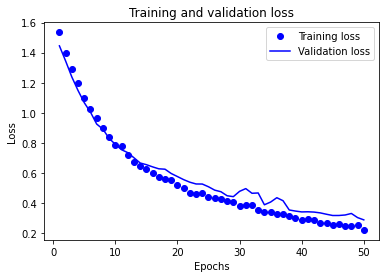

In [15]:
"""PLOTTING - Training and validation loss"""
import matplotlib.pyplot as plt

#METRICS
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#PLOT
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

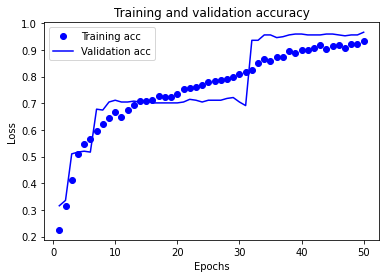

In [17]:
"""PLOTTING - Training and validation accuracy"""
plt.clf()

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [38]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
testing_x = {'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']}

y_preds = model.predict(testing_x)
for idx, l in enumerate(y_preds): 
    coded = np.zeros(5)
    coded[np.argmax(l, axis = 0)] = 1.0
    y_preds[idx] = coded

target_names = [k for k,v in label_map.items()]
accuracy = np.round(accuracy_score(test_y, y_preds), 4)
weighted_f1 = np.round(f1_score(test_y, y_preds, average = 'weighted'), 4)

print("ACCURACY %: ", accuracy)
print("WEIGHTED F1: ", weighted_f1)
print(classification_report(test_y, y_preds, target_names = target_names))

ACCURACY %:  0.9664
WEIGHTED F1:  0.9665
               precision    recall  f1-score   support

     business       0.93      0.97      0.95        64
entertainment       0.97      0.95      0.96        61
     politics       0.98      0.96      0.97        47
        sport       0.99      0.99      0.99        73
         tech       0.98      0.96      0.97        53

    micro avg       0.97      0.97      0.97       298
    macro avg       0.97      0.97      0.97       298
 weighted avg       0.97      0.97      0.97       298
  samples avg       0.97      0.97      0.97       298



In [39]:
pf.store_results('distilbert', '', model, accuracy, weighted_f1, tf_model=1)

INFO:tensorflow:Assets written to: models/distilbert-\assets


INFO:tensorflow:Assets written to: models/distilbert-\assets
c:\Users\deguz\OneDrive\PET_PROJECTS\Multiclass_Classification-News_Articles\process_funcs.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  'model': model_concat,
